# Julia is Fast - `@time`, `@elapsed` and `@inbounds`

---

In this notebook, we demonstrate how fast `Julia` is, compared to other dynamically typed languages. 

## Prerequisites

Read the text [Why Julia?](https://github.com/stevengj/julia-mit/blob/master/README.md#why-julia) (3 min)

Read [Performance tips](http://julia.readthedocs.org/en/latest/manual/performance-tips/) section of the `Julia` manual. (20 min) 

## Competences 

The reader should understand effects of "[just-in-time
compiler](https://en.wikipedia.org/wiki/Just-in-time_compilation)"
called [LLVM](http://llvm.org/) on the speed of execution of programs. 
The reader should be able to write simple, but fast, programs containing loops.

## Credits 

Some examples are taken from [The Julia Manual](http://julia.readthedocs.org/en/latest/manual/).


## Scholarly example - summing integer halves

Consider the function `f` which sums halves of integers from `1` to `n`:

__N.B.__ `Esc l` toggles the line numbers in the current cell.

In [1]:
function f(n)
    s = 0
    for i = 1:n
        s += i/2
    end
    s
end

f (generic function with 1 method)

In order for the fast execution, the function must first be compiled. Compilation is performed automatically, when the function is invoked for the first time. Therefore, the first call can be done with some trivial choice of parameters.

The timing can be done by two commands, `@time` and `@elapsed`: 

In [2]:
?@time

```
@time
```

A macro to execute an expression, printing the time it took to execute, the number of allocations, and the total number of bytes its execution caused to be allocated, before returning the value of the expression.

See also [`@timev`](:func:`@timev`), [`@timed`](:func:`@timed`), [`@elapsed`](:func:`@elapsed`), and [`@allocated`](:func:`@allocated`).


In [3]:
?@elapsed

```
@elapsed
```

A macro to evaluate an expression, discarding the resulting value, instead returning the number of seconds it took to execute as a floating-point number.

See also [`@time`](:func:`@time`), [`@timev`](:func:`@timev`), [`@timed`](:func:`@timed`), and [`@allocated`](:func:`@allocated`).


In [4]:
@time f(1) 

  0.019326 seconds (2.31 k allocations: 109.698 KB)


0.5

In [5]:
@elapsed f(1)  # This run is much faster, since the function is already compiled

2.593e-6

Let us now run the big-size computation. Notice the unnaturally high byte allocation and the huge amount of time spent on 
[garbage collection](http://en.wikipedia.org/wiki/Garbage_collection_%28computer_science%29).

In [6]:
@time f(1_000_000) # Notice the unnaturally high byte  allocation!

  0.063834 seconds (3.00 M allocations: 45.777 MB, 22.65% gc time)


2.5000025e11

In [7]:
@elapsed f(1000000) # We shall be using @time from now on

0.037920969

> Since your computer can execute several _Gigaflops_ (floating-point operations per second), this is rather slow. This slowness is due to _type instability_: variable `s` is in the beginning assumed to be of type `Integer`, while at every other step, the result is a real number of type `Float64`. Permanent checking of types requires permanent memory allocation and deallocation (garbage collection). This is corrected by very simple means: just declare `s` as a real number, and the execution is more than 10 times faster with almost no memory allocation (and, consequently, no garbage collection).

In [8]:
function f1(n)
    s = 0.0
    for i = 1:n
        s += i/2
    end
    s
end

f1 (generic function with 1 method)

In [9]:
@time f1(1)

  0.009505 seconds (1.50 k allocations: 69.192 KB)


0.5

In [11]:
@time f1(1000000)

  0.001784 seconds (5 allocations: 176 bytes)


2.5000025e11

`@time` can alo be invoked as a function, but only on a function call, and not when the output is assigned, as well:

In [12]:
@time(f1(1000000))

  0.001778 seconds (5 allocations: 176 bytes)


2.5000025e11

In [13]:
@time s2=f1(1000000)

  0.001778 seconds (6 allocations: 224 bytes)


2.5000025e11

In [14]:
@time(s2=f1(1000000))

LoadError: LoadError: syntax: unhandled expr (kw s2 (call f1 1000000))
while loading In[14], in expression starting on line 1

## Real-world example - exponential moving average

[Exponential moving average](http://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) is a fast _one pass_ formula (each data point of the given data set $A$ is accessed only once) often used in high-frequency on-line trading (see [Online Algorithms in High-Frequency Trading](http://cacm.acm.org/magazines/2013/10/168184-online-algorithms-in-high-frequency-trading/fulltext) for more details). __Notice that the output array $X$ is declared in advance.__

Using `return` in the last line is here optional.


In [15]:
function fexpma{T}( A::Vector{T}, alpha::T )
    # fast exponential moving average: X - moving average, A - data, 
    # alpha - exponential forgetting parameter
    n = length(A)
    X = Array(T,n) # Declare X
    beta = one(T)-alpha
    X[1] = A[1]
    for k = 2:n
        X[k] = beta*A[k] + alpha*X[k-1]
    end
    return X
end


fexpma (generic function with 1 method)

In [16]:
fexpma([1.0],0.5) # First run for compilation

1-element Array{Float64,1}:
 1.0

We now generate some big-size data:

In [20]:
# Big random slightly increasing sequence
A=[rand() + 0.00001*k*rand() for k=1:20_000_000] 

20000000-element Array{Float64,1}:
   0.951897 
   0.919728 
   0.496077 
   0.155213 
   0.216116 
   0.402744 
   0.731055 
   0.792958 
   0.854402 
   0.0133123
   0.628194 
   0.297872 
   0.0760056
   ⋮        
  50.3444   
 101.117    
  19.3756   
   6.31159  
  84.6788   
 160.222    
 176.518    
 198.244    
  61.3962   
  44.5321   
  31.4425   
  32.5703   

In [21]:
@time X=fexpma(A,0.9)

  0.218198 seconds (6 allocations: 152.588 MB, 33.97% gc time)


20000000-element Array{Float64,1}:
   0.951897
   0.948681
   0.90342 
   0.828599
   0.767351
   0.73089 
   0.730907
   0.737112
   0.748841
   0.675288
   0.670579
   0.633308
   0.577578
   ⋮       
  93.8313  
  94.5598  
  87.0414  
  78.9684  
  79.5394  
  87.6077  
  96.4987  
 106.673   
 102.146   
  96.3842  
  89.89    
  84.158   

## `@inbounds`

The `@inbounds` command eliminates array bounds checking within expressions. Be certain before doing this. If the subscripts are ever out of bounds, you may suffer crashes or silent corruption. The above program runs 40% faster.,

In [22]:
function fexpma{T}( A::Vector{T}, alpha::T )
    # fast exponential moving average: X - moving average, A - data, 
    # alpha - exponential forgetting parameter
    n = length(A)
    X = Array(T,n) # Declare X
    beta = one(T)-alpha
    X[1] = A[1]
    @inbounds for k = 2:n
        X[k] = beta*A[k] + alpha*X[k-1]
    end
    return X
end

fexpma (generic function with 1 method)

In [25]:
@time X=fexpma(A,0.9)

  0.244917 seconds (6 allocations: 152.588 MB, 31.65% gc time)


20000000-element Array{Float64,1}:
   0.951897
   0.948681
   0.90342 
   0.828599
   0.767351
   0.73089 
   0.730907
   0.737112
   0.748841
   0.675288
   0.670579
   0.633308
   0.577578
   ⋮       
  93.8313  
  94.5598  
  87.0414  
  78.9684  
  79.5394  
  87.6077  
  96.4987  
 106.673   
 102.146   
  96.3842  
  89.89    
  84.158   

Similar `Matlab` programs give the following timing for the two versions of the function, first _without_ prior declaration of $X$ and then _with_ prior declaration. The _latter_ version is several times faster, but still slow. 

---
```
function X = fexpma0( A,alpha )
% fast exponential moving average: X - moving average, A - data, 
% alpha - exponential forgetting parameter
n=length(A);
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> A=rand(20000000,1)+0.00001*[1:20000000]'.*rand(20000000,1);
>> tic, X=fexpma0(A,0.9); toc
Elapsed time is 3.073359 seconds.
```

---

```
function X = fexpma( A,alpha )
% fast exponential moving average: X - moving average, A - data, 
% alpha - exponential forgetting parameter
n=length(A);
X=zeros(n,1); % Allocate X in advance
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> tic, X=fexpma(A,0.9); toc
Elapsed time is 0.320976 seconds.
```

## Plotting the moving average

Let us plot the data $A$ and its exponential moving average $X$. The dimension of the data is too large for meaningful direct plot. In Julia we can use `@manipulate` command to slide through the data. It takes a while to read packages 
[Winston.jl](https://github.com/nolta/Winston.jl) (for plotting) and 
[Interact.jl](https://github.com/JuliaLang/Interact.jl), but this is needed only for the first invocation.

In [26]:
using Winston
using Interact

Interact.Slider{Int64}(Signal{Int64}(9999001, nactions=0),"k",9999001,1:1000:19999001,"d",true)

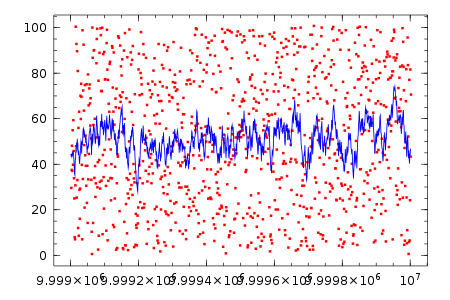

In [27]:
@manipulate for k=1:1000:20000000
    plot(collect(k:k+1000),A[k:k+1000],"r.",collect(k:k+1000),X[k:k+1000],"b")
end

### Remark
More details about optimizing your programs are given in the [Profiling Notebook]().

## Pre-allocating output

The following example is from [Pre-allocating outputs](http://julia.readthedocs.org/en/latest/manual/performance-tips/#pre-allocating-outputs). The functions `loopinc()` and `loopinc_prealloc()` both compute $\sum_{i=2}^{10000001}i$, the second one being 10 times faster: 

In [22]:
function xinc(x)
    return [x, x+1, x+2]
end

function loopinc()
    y = 0
    for i = 1:10^7
        ret = xinc(i)
        y += ret[2]
    end
    y
end

function xinc!{T}(ret::AbstractVector{T}, x::T)
    ret[1] = x
    ret[2] = x+1
    ret[3] = x+2
    nothing
end

function loopinc_prealloc()
    ret = Array(Int, 3)
    y = 0
    for i = 1:10^7
        xinc!(ret, i)
        y += ret[2]
    end
    y
end

loopinc_prealloc (generic function with 1 method)

In [25]:
@time loopinc()

  0.783323 seconds (40.00 M allocations: 1.341 GB, 15.60% gc time)


50000015000000

In [27]:
@time loopinc_prealloc() # After the second run

  0.040584 seconds (6 allocations: 272 bytes)


50000015000000

## Memory access

The following example is from [Access arrays in memory order, along columns](http://julia.readthedocs.org/en/latest/manual/performance-tips/#access-arrays-in-memory-order-along-columns).

Multidimensional arrays in Julia are stored in column-major order, which means that arrays are stacked one column at a time. This convention for ordering arrays is common in many languages like Fortran, Matlab, and R (to name a few). The alternative to column-major ordering is row-major ordering, which is the convention adopted by C and Python (numpy) among other languages. The ordering can be verified using the `vec()` function or the syntax `[:]`:

In [30]:
B = rand(0:9,4,3)

4x3 Array{Int64,2}:
 8  9  7
 1  4  1
 7  0  3
 8  4  4

In [31]:
B[:]

12-element Array{Int64,1}:
 8
 1
 7
 8
 9
 4
 0
 4
 7
 1
 3
 4

In [32]:
vec(B)

12-element Array{Int64,1}:
 8
 1
 7
 8
 9
 4
 0
 4
 7
 1
 3
 4

In [33]:
# Getting indices back
k=ind2sub(B,5)
k, B[5], B[k[1],k[2]]

((1,2),9,9)

The ordering of arrays can have significant performance effects when looping over arrays. Loops should be organized such that the subsequent accessed elements are close to each other in physical memory.

The following functions accept a `Vector` and and return a square `Array` with the rows or the columns filled with copies of the input vector, respectively.

In [34]:
function copy_cols{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(eltype(x), n, n)
    for i=1:n
        out[:, i] = x
    end
    out
end

function copy_rows{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(eltype(x), n, n)
    for i=1:n
        out[i, :] = x
    end
    out
end

copy_rows (generic function with 1 method)

In [38]:
println(copy_cols([1.0,2]))
copy_rows([1.0,2])

[1.0 1.0
 2.0 2.0]


2x2 Array{Float64,2}:
 1.0  2.0
 1.0  2.0

In [39]:
x=rand(5000) # generate a random vector

5000-element Array{Float64,1}:
 0.0856634
 0.321472 
 0.0886528
 0.38623  
 0.239008 
 0.728354 
 0.479514 
 0.53445  
 0.972151 
 0.277445 
 0.498325 
 0.394859 
 0.857936 
 ⋮        
 0.509348 
 0.961835 
 0.146581 
 0.648268 
 0.187937 
 0.170023 
 0.0328133
 0.235032 
 0.123022 
 0.78216  
 0.404876 
 0.720746 

In [41]:
@time C=copy_cols(x)  # We generate a large matrix

  0.096599 seconds (4.50 k allocations: 190.804 MB, 3.18% gc time)


5000x5000 Array{Float64,2}:
 0.0856634  0.0856634  0.0856634  …  0.0856634  0.0856634  0.0856634
 0.321472   0.321472   0.321472      0.321472   0.321472   0.321472 
 0.0886528  0.0886528  0.0886528     0.0886528  0.0886528  0.0886528
 0.38623    0.38623    0.38623       0.38623    0.38623    0.38623  
 0.239008   0.239008   0.239008      0.239008   0.239008   0.239008 
 0.728354   0.728354   0.728354   …  0.728354   0.728354   0.728354 
 0.479514   0.479514   0.479514      0.479514   0.479514   0.479514 
 0.53445    0.53445    0.53445       0.53445    0.53445    0.53445  
 0.972151   0.972151   0.972151      0.972151   0.972151   0.972151 
 0.277445   0.277445   0.277445      0.277445   0.277445   0.277445 
 0.498325   0.498325   0.498325   …  0.498325   0.498325   0.498325 
 0.394859   0.394859   0.394859      0.394859   0.394859   0.394859 
 0.857936   0.857936   0.857936      0.857936   0.857936   0.857936 
 ⋮                                ⋱                                 
 0.509

In [42]:
@time D=copy_rows(x) # This is several times slower

  0.317656 seconds (4.50 k allocations: 190.804 MB, 10.32% gc time)


5000x5000 Array{Float64,2}:
 0.0856634  0.321472  0.0886528  0.38623  …  0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623  …  0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623  …  0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 0.0856634  0.321472  0.0886528  0.38623     0.78216  0.404876  0.720746
 ⋮                     

### Remark
There is also a built-in function `repmat()`:

In [43]:
?repmat

search: repmat



```
repmat(A, n, m)
```

Construct a matrix by repeating the given matrix `n` times in dimension 1 and `m` times in dimension 2.


In [44]:
@time C1=repmat(x,1,5000)

  0.230970 seconds (60.22 k allocations: 193.392 MB, 28.16% gc time)


5000x5000 Array{Float64,2}:
 0.0856634  0.0856634  0.0856634  …  0.0856634  0.0856634  0.0856634
 0.321472   0.321472   0.321472      0.321472   0.321472   0.321472 
 0.0886528  0.0886528  0.0886528     0.0886528  0.0886528  0.0886528
 0.38623    0.38623    0.38623       0.38623    0.38623    0.38623  
 0.239008   0.239008   0.239008      0.239008   0.239008   0.239008 
 0.728354   0.728354   0.728354   …  0.728354   0.728354   0.728354 
 0.479514   0.479514   0.479514      0.479514   0.479514   0.479514 
 0.53445    0.53445    0.53445       0.53445    0.53445    0.53445  
 0.972151   0.972151   0.972151      0.972151   0.972151   0.972151 
 0.277445   0.277445   0.277445      0.277445   0.277445   0.277445 
 0.498325   0.498325   0.498325   …  0.498325   0.498325   0.498325 
 0.394859   0.394859   0.394859      0.394859   0.394859   0.394859 
 0.857936   0.857936   0.857936      0.857936   0.857936   0.857936 
 ⋮                                ⋱                                 
 0.509